In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import urllib
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("data/wsb_interim.csv", index_col=0)

In [3]:
df2 = df[ df['body'].isna() ]

In [4]:
df2[df2.type=='image'].sample(10)['url']

29231      https://i.redd.it/cw5bnzhs71d61.jpg
19188      https://i.redd.it/w32qhsded3e61.png
12340      https://i.redd.it/nk71e1nc3xc61.png
37840      https://i.redd.it/oi0vn1wh6if61.png
37068      https://i.redd.it/s53bjn17qde61.jpg
16183      https://i.redd.it/t3xeblqoz2f61.jpg
26107      https://i.redd.it/kr8aba6gshe61.jpg
38794      https://i.redd.it/uet9y9kr43e61.jpg
18251    https://www.reddit.com/gallery/l47bt6
38475      https://i.redd.it/xeo9r08rrwd61.jpg
Name: url, dtype: object

In [5]:
df2.head()

,title,score,id,url,comms_num,body,timestamp,upvote_ratio,is_oc,permalink,...,body_raw,title_length,title_capital,body_length,body_urls,body_punct,type,deleted,body_bow,title_bow
1,"['hold', 'GME', 'till', 'squeeze', 'squoze']",1157,l87ci6,https://i.redd.it/20f2x4ehsce61.png,85,NaN,2021-01-30 00:12:20,0.99,False,/r/wallstreetbets/comments/l87ci6/holding_gme_...,...,NaN,9,0.117647,NaN,0,0,image,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"['buy', 'DIP', 'hold', 'rocket', 'rocket', 'ro...",15,l6955d,https://www.reddit.com/r/wallstreetbets/commen...,2,NaN,2021-01-27 18:06:55,1.00,False,/r/wallstreetbets/comments/l6955d/buy_the_dip_...,...,NaN,8,0.842105,NaN,0,0,text,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,"['inability', 'rh', 'user', 'purchase', 'AMC',...",19,l6wtpf,https://www.reddit.com/r/wallstreetbets/commen...,8,NaN,2021-01-28 14:40:05,1.00,False,/r/wallstreetbets/comments/l6wtpf/due_to_the_i...,...,NaN,45,0.069767,NaN,0,0,text,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13,"['new', 'fill', 'order', 'dip', 'pray', 'fill'...",9,l720fg,https://www.reddit.com/r/wallstreetbets/commen...,2,NaN,2021-01-28 17:50:08,1.00,False,/r/wallstreetbets/comments/l720fg/put_in_a_new...,...,NaN,26,0.125000,NaN,0,0,text,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
20,"['big', 'loss', 'lot', 'money', 'stay', 'stron...",30,lcj6n5,https://i.redd.it/7hswv66yjhf61.png,2,NaN,2021-02-04 17:16:33,0.85,False,/r/wallstreetbets/comments/lcj6n5/not_as_big_o...,...,NaN,22,0.034483,NaN,0,0,image,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
import time

path = 'images/'

def download_image(name, url):
    if '.jpg' in url or '.png' in url:
        
        try:
            req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})   

            html = urllib.request.urlopen(req)
            arr = np.asarray(bytearray(html.read()), dtype=np.uint8)
            img = cv2.imdecode(arr, -1)
            cv2.imwrite(path+name+'.jpg', img)
            
        except:
            pass
        
        finally:
            pass

In [7]:
len(df2[ df2['url'].str.contains('.jpg') | df2['url'].str.contains('.png') ])

10828

In [8]:
len(df2[ df2['url'].str.contains('gallery') ])

993

In [9]:
len(df2[ df2['url'].str.contains('youtube') | df2['url'].str.contains('youtu.be') ])

233

In [10]:
len(df2[ df2['url'].str.contains('twitter') ])

296

In [11]:
len(df2[ df2['url'].str.contains('v.redd') ])

717

In [12]:
len(df2)

18205

## Download images

In [13]:
from tqdm.notebook import tqdm

for index, row in tqdm(df2.iterrows()):
    download_image(row['id'], row['url'])
    time.sleep(0.1)

# df2.apply(lambda x: download_image(x['id'], x['url']), axis=1)

## OCR Tesseract

In [15]:
from pytesseract import Output
import pytesseract

pytesseract.pytesseract.tesseract_cmd = 'D:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [23]:
def resize(img):
    w = img.shape[1]
    h = img.shape[0]
    
    if w > 400 or h > 400:
        scale_factor = 400 / w if w > h else 400 / h
    else:
        return img
    
    width = int(w * scale_factor)
    height = int(h * scale_factor)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def get_text(path):
    image = cv2.imread(path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pytesseract.image_to_data(rgb, output_type=Output.DICT)
    
    texts = []
    for i in range(0, len(results["text"])):
        text = results["text"][i]
        conf = int(results["conf"][i])
        
        if conf > 50:
            texts.append(text)
            
    return ' '.join(texts)

In [17]:
samp = "images/l6h59b.jpg"
get_text(samp)

'melvin of underpants being up your but crack, they ride up labia, ‘tis mot okay t pic your Melvin public. by alicenwundrind October 14,2014 '

In [24]:
import pickle

tess = []
tess_names = []

In [25]:
directory = "./images"

for idx, filename in enumerate(tqdm(os.listdir(directory))):
    tess.append(get_text(os.path.join(directory, filename)))
    tess_names.append(filename.split('.')[0])
    
    if idx % 1000 == 0:
        print(f"Checkpoint {idx}")
        with open('backup/ocr_tesseract_checkpoint.pickle', 'wb') as handle:
            pickle.dump(tess, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
        with open('backup/ocr_names_tesseract_checkpoint.pickle', 'wb') as handle:
            pickle.dump(tess_names, handle, protocol=pickle.HIGHEST_PROTOCOL)

Checkpoint 0
Checkpoint 1000
Checkpoint 2000
Checkpoint 3000
Checkpoint 4000
Checkpoint 5000
Checkpoint 6000
Checkpoint 7000
Checkpoint 8000
Checkpoint 9000
Checkpoint 10000



In [27]:
import pickle

with open('backup/ocr_tesseract.pickle', 'wb') as handle:
    pickle.dump(tess, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('backup/ocr_names_tesseract.pickle', 'wb') as handle:
    pickle.dump(tess_names, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Load from pickle

In [6]:
import pickle

with open('backup/ocr_tesseract.pickle', 'rb') as handle:
    tess = pickle.load(handle)
    
with open('backup/ocr_names_tesseract.pickle', 'rb') as handle:
    tess_names = pickle.load(handle)

In [7]:
df_ocr = pd.DataFrame(zip(tess_names, tess), columns=["id", "text"])

In [8]:
df_ocr

,id,text
0,l0j2uy,Palantir announces multi- million dollar deal ...
1,l0jw5j,Ursula von der Leyen @ @vonderleyen Clean...
2,l0k6vs,Benzinga Pro's Top 5 Stocks To Watch For Tuesd...
3,l0k7wq,= BASTOGNE «
4,l0khnn,09:060R @ € News TRADE (NELX) - Will report Q4...
...,...,...
10625,lh8j7j,4:20 all> @) < ® 1D 1W Your Position Shares Ma...
10626,lh9q18,3:57 7 all > $63.99 < TLRY @ V vv 1M 3M 1Y 5Y ...
10627,lh9t7w,"6:35 all $7,173.63 V $19,170.96 (72.77%) Oct 2..."
10628,lhaeyc,Corsair Gaming $42.87 (-4.08%) CRSR $70 Call $...


In [9]:
import spacy
import nltk
import re

from nltk.stem.porter import *

nlp = spacy.load("en_core_web_sm")

TIME = r"\d{1,2}:\d{2}"
EXP = re.compile(TIME)

def lemmatization(x):
    if type(x) == spacy.tokens.doc.Doc:
        return [token.lemma_ for token in x if not token.is_stop and token.is_alpha]
    return x

def type_check(x):
    return type(x) == spacy.tokens.doc.Doc

def get_caps(x):
    if type_check(x):
        caps_perc = 0
        title_len = 0
        for token in x:
            title_len += len(token.shape_)
            caps_perc += token.shape_.count('X')
            
        if title_len != 0:
            return caps_perc / title_len
    return 0.0

def is_twitt(x):
    if 'Twitt' in x:
        return 1
    return 0

def get_features(df):
    df['twitter'] = df['text'].apply(is_twitt)
    df['text'] = df['text'].apply(lambda x: nlp(x))
    df['text_bow'] = df['text'].apply(lemmatization)
    df['text_length'] = df['text'].apply(lambda x: len(x))
    df['text_capital'] = df['text'].apply(get_caps)
    return df

In [10]:
df_ocr_proc = get_features(df_ocr)

In [11]:
df_ocr_proc

,id,text,twitter,text_bow,text_length,text_capital
0,l0j2uy,"(Palantir, announces, multi-, million, dollar,...",0,"[Palantir, announce, million, dollar, deal, PL...",40,0.229167
1,l0jw5j,"( , Ursula, von, der, Leyen, @, @vonderley...",0,"[Ursula, von, der, Leyen, clean, hydrogen, hel...",62,0.068627
2,l0k6vs,"(Benzinga, Pro, 's, Top, 5, Stocks, To, Watch,...",0,"[Benzinga, Pro, stock, Watch, Tuesday, NFLX, M...",175,0.129344
3,l0k7wq,"( , =, BASTOGNE, «)",0,[BASTOGNE],4,0.500000
4,l0khnn,"(09:060R, @, €, News, TRADE, (, NELX, ), -, Wi...",0,"[News, TRADE, NELX, report, earning, market, c...",180,0.114964
...,...,...,...,...,...,...
10625,lh8j7j,"(4:20, all, >, @, ), <, ®, 1D, 1W, Your, Posit...",0,"[Position, Shares, market, Value, Avg, Cost, P...",52,0.111111
10626,lh9q18,"(3:57, 7, all, >, $, 63.99, <, TLRY, @, V, vv,...",0,"[TLRY, v, vv, M, M, Options, Contracts, Value,...",68,0.143519
10627,lh9t7w,"(6:35, all, $, 7,173.63, V, $, 19,170.96, (, 7...",0,"[v, oct, M, M, Buying, Power, ws, Reuters, m, ...",316,0.128017
10628,lhaeyc,"(Corsair, Gaming, $, 42.87, (, -4.08, %, ), CR...",0,"[corsair, game, CRSR, today, Ww, Market, Value...",58,0.147959


In [12]:
from collections import Counter

def get_vocab(data, n):
    words = Counter()
    for i in data.index:
        words.update(data.at[i])

    return words

def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts).rename(columns={0:'Token', 1:'Count'})
    
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Token", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

In [13]:
df_ocr_proc['text_bow'] = df_ocr_proc['text_bow'].fillna(value='')
vocab = get_vocab(df_ocr_proc['text_bow'], 1000)

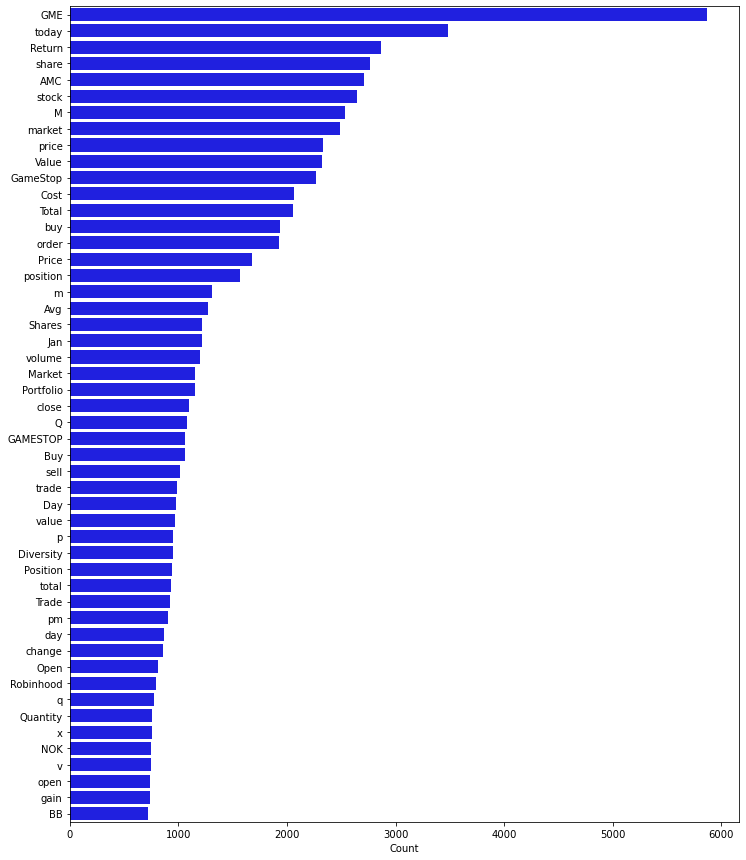

In [14]:
show_histogram(vocab.most_common(50))

In [15]:
def bag_of_words(x, most_freq):
    sent_vec = []
    for token in most_freq:
        if token in x:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    return sent_vec

In [16]:
feature_dict = [key for key, _ in vocab.most_common(200)]

df_ocr_proc['text_bow'] = df_ocr_proc['text_bow'].apply(lambda x: bag_of_words(x, feature_dict))

In [17]:
df_ocr_proc = df_ocr_proc.drop("text", axis=1)
df_ocr_proc.head()

,id,twitter,text_bow,text_length,text_capital
0,l0j2uy,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,0.229167
1,l0jw5j,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",62,0.068627
2,l0k6vs,0,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",175,0.129344
3,l0k7wq,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.500000
4,l0khnn,0,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",180,0.114964


## Color Palette

In [20]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_palette(img):
    palette = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    palette_colors = np.unique(palette, return_counts=True, axis=0)
    hex_palette = np.apply_along_axis(RGB2HEX, 1, palette_colors[0])
    palette_tup = zip(hex_palette.tolist(), palette_colors[1].tolist())
    sorted_tup = sorted(palette_tup, key=lambda x: x[1], reverse=True)    
    return [color[0] for color in sorted_tup]

In [18]:
from sklearn.cluster import MiniBatchKMeans
import webcolors
import colorsys

def quantize(im):
    (h, w) = im.shape[:2]
    image = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)

    image = image.reshape((image.shape[0] * image.shape[1], 3))

    clt = MiniBatchKMeans(n_clusters = 8)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]
    quant = quant.reshape((h, w, 3))
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
    
    return quant

def RGB2HSV(color):
    h, s, v = colorsys.rgb_to_hsv(*color)
    return h

def get_closest_color(color):
    min_colors = {}
    if colors is not None:
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - color[0]) ** 2
            gd = (g_c - color[1]) ** 2
            bd = (b_c - color[2]) ** 2
            min_colors[(rd + gd + bd)] = name
        return min_colors[min(min_colors.keys())]
    return color

def get_palette(img):
    img = quantize(img)
    palette = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    palette_colors = np.unique(palette, return_counts=True, axis=0)
    hue_palette = np.apply_along_axis(RGB2HSV, 1, palette_colors[0])
    #hex_palette = np.apply_along_axis(get_closest_color, 1, palette_colors[0])
    palette_tup = zip(hue_palette.tolist(), palette_colors[1].tolist())
    sorted_tup = sorted(palette_tup, key=lambda x: x[1], reverse=True)    
    return [color[0] for color in sorted_tup]

In [20]:
directory = "./images"

width = 100
height = 100
dim = (width, height)
colors = []
color_names = []

for idx, filename in enumerate(tqdm(os.listdir(directory))):
    im = cv2.imread(os.path.join(directory, filename))
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
 
    # resize image
    resized = cv2.resize(im_rgb, dim, interpolation = cv2.INTER_AREA)
    
    colors.append(get_palette(resized))
    color_names.append(filename.split('.')[0])

In [21]:
col_names = [f"col{x}" for x in range(8)]

In [22]:
colors_df = pd.DataFrame(colors, columns=col_names)

In [23]:
id_col = pd.DataFrame(color_names, columns=['id'])

In [24]:
df_colors = pd.concat([id_col, colors_df], axis=1)
df_colors

,id,col0,col1,col2,col3,col4,col5,col6,col7
0,l0j2uy,0.500000,0.566667,0.533333,0.547619,0.541667,0.583333,0.541667,0.000000
1,l0jw5j,0.566667,0.600000,0.643875,0.966667,0.680233,0.625786,0.051282,0.710145
2,l0k6vs,0.000000,0.000000,0.000000,0.000000,0.944444,0.986111,0.991546,0.991228
3,l0k7wq,0.523810,0.511364,0.311111,0.384615,0.407407,0.148718,0.388889,0.996633
4,l0khnn,0.500000,0.533333,0.533333,0.533333,0.533333,0.541667,0.562500,0.666667
...,...,...,...,...,...,...,...,...,...
10625,lh8j7j,0.333333,0.466667,0.333333,0.583333,0.541667,0.333333,0.350000,0.339623
10626,lh9q18,0.500000,0.500000,0.366667,0.000000,0.000000,0.297158,0.305556,0.000000
10627,lh9t7w,0.583333,0.500000,0.416667,0.444444,0.307018,0.000000,0.302326,0.305556
10628,lhaeyc,0.666667,0.611111,0.611111,0.583333,0.038690,0.583333,0.333333,0.033708


In [25]:
df_colors.to_csv("backup/colors.csv", index=False)

#### Load from csv

In [26]:
df_colors = pd.read_csv("backup/colors.csv")
df_colors.head()

,id,col0,col1,col2,col3,col4,col5,col6,col7
0,l0j2uy,0.500000,0.566667,0.533333,0.547619,0.541667,0.583333,0.541667,0.000000
1,l0jw5j,0.566667,0.600000,0.643875,0.966667,0.680233,0.625786,0.051282,0.710145
2,l0k6vs,0.000000,0.000000,0.000000,0.000000,0.944444,0.986111,0.991546,0.991228
3,l0k7wq,0.523810,0.511364,0.311111,0.384615,0.407407,0.148718,0.388889,0.996633
4,l0khnn,0.500000,0.533333,0.533333,0.533333,0.533333,0.541667,0.562500,0.666667


## Feature extraction

In [31]:
import os
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.models import Model

In [32]:
model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=True)

In [33]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [34]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

shape of x:  (1, 224, 224, 3)
data type:  float32


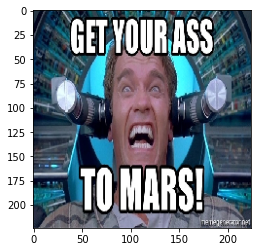

In [35]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

img, x = load_image("images/l6hez2.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

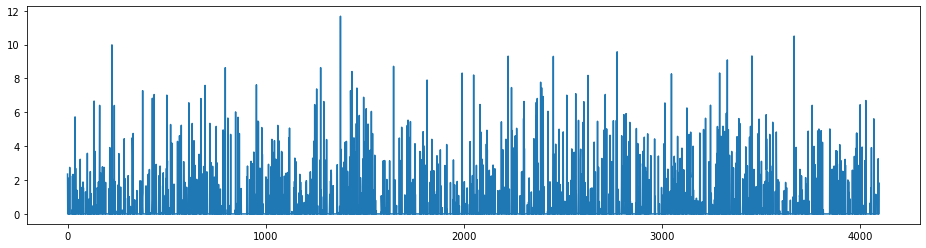

In [36]:
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [37]:
directory = "./images"
features = []
names = []

for idx, filename in enumerate(os.listdir(directory)):
    if idx % 1000 == 0:
        print("analyzing image %d" % (idx))
    img, x = load_image(os.path.join(directory, filename))
    feat = feat_extractor(x, training=False)[0]
    
    features.append(feat)
    names.append(filename.split('.')[0])

analyzing image 0
analyzing image 1000
analyzing image 2000
analyzing image 3000
analyzing image 4000
analyzing image 5000
analyzing image 6000
analyzing image 7000
analyzing image 8000
analyzing image 9000
analyzing image 10000


In [38]:
import pickle

with open('backup/visual_features.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
with open('backup/visual_names.pickle', 'wb') as handle:
    pickle.dump(names, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Load from pickle

In [34]:
with open('backup/visual_features.pickle', 'rb') as handle:
    features = pickle.load(handle)
    
with open('backup/visual_names.pickle', 'rb') as handle:
    names = pickle.load(handle)

In [41]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=100)
pca.fit(features)

PCA(n_components=100)

In [42]:
print(pca.explained_variance_ratio_)

[0.17176275 0.14985533 0.06057297 0.0452063  0.03385099 0.03256629
 0.02897501 0.02065022 0.01656629 0.01380707 0.01224022 0.011577
 0.01080338 0.01018011 0.00967959 0.00892254 0.00784174 0.00759279
 0.00700161 0.00641897 0.00581466 0.00548838 0.00517806 0.00481684
 0.00471746 0.00441312 0.00429635 0.00418543 0.0041065  0.00391899
 0.00377286 0.00362164 0.00352729 0.00336914 0.00315539 0.00310102
 0.0030748  0.0029022  0.00281257 0.00278031 0.00262714 0.00258067
 0.00243768 0.00241397 0.00236171 0.00226783 0.00218387 0.0021618
 0.00211839 0.00209021 0.00198856 0.00196344 0.00193538 0.00188543
 0.00180772 0.0017726  0.00174166 0.00172075 0.00164473 0.00161194
 0.00157121 0.00154225 0.00151977 0.00149506 0.00145504 0.00142373
 0.0013958  0.00137862 0.00137283 0.00134816 0.00132144 0.00129644
 0.00126865 0.0012457  0.00121891 0.00120495 0.00118848 0.00115933
 0.00115102 0.00114149 0.00111328 0.00110137 0.00108805 0.00106569
 0.00105394 0.00104286 0.0010039  0.00099505 0.00098101 0.000967


In [43]:
pca_features = pca.transform(features)

In [44]:
with open('backup/visual_pca_features.pickle', 'wb') as handle:
    pickle.dump(pca_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Load from pickle

In [27]:
with open('backup/visual_pca_features.pickle', 'rb') as handle:
    pca_features = pickle.load(handle)

In [28]:
pca_features

array([[-9.7784414e+00, -2.4707714e+01, -1.5613345e+01, ...,
        -2.1395612e-01,  7.6333582e-01,  8.6966860e-01],
       [-1.5861920e+01, -1.3200171e+00, -1.5529302e+01, ...,
        -2.6138926e-01, -2.4041111e+00,  2.6410294e-01],
       [-9.8067713e+00, -1.2846659e+01, -2.1638662e+01, ...,
         1.1637627e+00, -6.3987261e-01, -4.6188530e-01],
       ...,
       [-7.3069649e+00,  2.7428793e+01,  3.3833508e+01, ...,
         6.6787636e-01, -3.0974263e-01,  3.1297231e+00],
       [-1.1756054e+01,  1.1654500e+01,  1.0767333e+01, ...,
         1.1673625e+00, -2.4750175e+00,  4.3308920e-01],
       [-3.0981594e+01,  2.0549591e+01,  3.6421398e+01, ...,
        -1.7579998e+00, -7.0620114e-01, -1.5829563e-02]], dtype=float32)

In [29]:
pca_features_reduced = pca_features[:, :13]

In [30]:
pca_features_reduced.shape

(10630, 13)

In [31]:
df_pca = pd.DataFrame(pca_features_reduced)
df_pca.shape

(10630, 13)

In [35]:
df_pca['id'] = names

In [36]:
df_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,id
0,-9.778441,-24.707714,-15.613345,0.718980,-1.149603,-1.947309,-4.740125,-13.350494,10.041041,-0.277502,-1.350466,1.800887,8.404503,l0j2uy
1,-15.861920,-1.320017,-15.529302,4.561495,-7.948915,0.232046,-8.669718,15.691691,4.067730,-0.449462,-1.699930,1.796376,-10.906918,l0jw5j
2,-9.806771,-12.846659,-21.638662,-8.387584,10.683289,8.197580,-0.654460,-5.188345,2.994244,2.001646,-2.542726,0.144770,-0.092432,l0k6vs
3,-19.837250,-23.830692,2.321813,10.697480,-21.758307,5.091673,-4.672430,19.499205,2.614788,9.483265,0.321465,-6.307117,-1.994259,l0k7wq
4,-5.952649,4.645163,-26.208317,-2.566991,5.856569,16.374063,6.678858,5.530633,4.426989,1.039345,-5.990426,0.222307,-5.609296,l0khnn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10625,-13.152501,29.792957,15.582088,-19.730324,-17.513962,-3.823084,14.648697,-10.536871,9.621264,-9.382256,-0.971067,3.258287,1.082165,lh8j7j
10626,42.742382,-2.659632,12.798088,-4.240649,-12.191031,0.893692,-0.602096,-6.180359,-1.247412,0.070137,0.976334,2.006495,-6.616879,lh9q18
10627,-7.306965,27.428793,33.833508,10.910515,5.536849,6.347808,14.122611,-2.540338,11.896130,-5.308099,-13.186190,5.320441,1.720898,lh9t7w
10628,-11.756054,11.654500,10.767333,-9.302024,-1.621235,-11.238375,27.106276,6.907452,-9.639314,-3.745684,-3.860185,-2.126068,8.976760,lhaeyc


# Image ratio

In [37]:
directory = "./images"

def get_ratio(path):
    image = cv2.imread(path)
    w = image.shape[1]
    h = image.shape[0]
    return w / h

ratio = []
ratio_names = []

for idx, filename in enumerate(tqdm(os.listdir(directory))):
    ratio.append(get_ratio(os.path.join(directory, filename)))
    ratio_names.append(filename.split('.')[0])

In [38]:
df_ratio = pd.DataFrame(zip(ratio_names, ratio), columns=["id", "ratio"])
df_ratio['screenshot'] = df_ratio['ratio'] <= 0.5625
df_ratio = df_ratio.drop('ratio', axis=1)
df_ratio

,id,screenshot
0,l0j2uy,False
1,l0jw5j,False
2,l0k6vs,False
3,l0k7wq,False
4,l0khnn,True
...,...,...
10625,lh8j7j,True
10626,lh9q18,True
10627,lh9t7w,False
10628,lhaeyc,False


# Merge and save dataframe

In [39]:
df_colors.shape

(10630, 9)

In [40]:
df_ocr_proc.shape

(10630, 5)

In [41]:
df_final = df_colors.set_index('id').join(df_ocr_proc.set_index('id'))
df_final.head()

,col0,col1,col2,col3,col4,col5,col6,col7,twitter,text_bow,text_length,text_capital
id,,,,,,,,,,,,
l0j2uy,0.500000,0.566667,0.533333,0.547619,0.541667,0.583333,0.541667,0.000000,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,0.229167
l0jw5j,0.566667,0.600000,0.643875,0.966667,0.680233,0.625786,0.051282,0.710145,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",62,0.068627
l0k6vs,0.000000,0.000000,0.000000,0.000000,0.944444,0.986111,0.991546,0.991228,0,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",175,0.129344
l0k7wq,0.523810,0.511364,0.311111,0.384615,0.407407,0.148718,0.388889,0.996633,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.500000
l0khnn,0.500000,0.533333,0.533333,0.533333,0.533333,0.541667,0.562500,0.666667,0,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",180,0.114964


In [42]:
df_final = df_final.join(df_pca.set_index('id'))
df_final = df_final.join(df_ratio.set_index('id'))

In [43]:
df_final.shape

(10630, 26)

In [44]:
df_final.to_csv("data/wsb_visuals.csv")